<a href="https://colab.research.google.com/github/Beh-noush/TT-classification/blob/main/TN_classification_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****We will adjust this code for the case of multi-class classification. That is, the function 'make_tensor' wont use the command 'tl.tt_to_tensor' or 'tl.cp_to_tensor' any more. 

In [1]:
import pickle
import string
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import math
from torch import einsum
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
torch.manual_seed(0)

torch.cuda.is_available()

if torch.cuda.is_available:
  dev = 'cuda:0'
else:
  dev = 'CPU'

device = torch.device(dev)

from tqdm import tqdm
!pip install tensorly
import tensorly as tl
tl.set_backend('pytorch')

     |████████████████████████████████| 198 kB 4.2 MB/s 
     |████████████████████████████████| 154 kB 37.0 MB/s 


In [2]:
def unit(A,B):
  return(torch.einsum('ij, ik -> ijk', A,B))

In [3]:
def make_tensor(core_tensors, decompos):
  """
  computes the tensor made up of "core_tensors" according to a given tensor decomposition, "decompos".
  
  Parameters
  -------
  core_tensors: list
               list of cores of the corresponding tensor decomposition.
  
  decomposition: str
                the name of a decomposition. Ex, CP, Tucker, TT, etc.
  Returns
  ------
  tensor
    Tensor made up of core tensors.
  """
  if decompos == 'TT':
    W = tl.tt_to_tensor(core_tensors)
  if decompos == 'CP':
    rank = core_tensors[0].shape[1]
    dev = core_tensors[0].device
    W = tl.cp_to_tensor((torch.ones(rank).to(dev),core_tensors))
  if decompos == 'HT':
    W = ht_to_tensor_top_buttom(core_tensors)
  return W

In [4]:
def inner_product(data_tensor, weight_tensor):
  """
  Computes the inner products  between a batch of tensors and a weight tensor

  Parameters
  -------
  data_tensor: torch tensor
               batch of input tensors of size n x d_1 x ... x d_p
  weight_tensor: torch tensor
               tensor of order p, the weight tensor of the model.

  Returns
  ------
  vector
    Vector of size n containing the inner products 
  """
  return torch.matmul(data_tensor.reshape([data_tensor.shape[0],-1]),weight_tensor.ravel())

In [5]:
def ht_to_tensor_top_buttom(core_tensors):
  """
  computes the tensor made up of "core_tensors" according to binary hierarchical Tucker decomposition".
  
  Parameters
  -------
  core_tensors: list
               list of cores of the HT decomposition in this order: [[root], [[ Level 2], [ Level 3] , .... , [Leaves] ] ]
  
  Returns
  ------
  tensor
    Tensor made up of core tensors.
  """
  root = core_tensors[0]
  interior_levels = core_tensors[1] #interior_levels includes all levels but the first one containing the root.

  tree = root[0]
  for cores in interior_levels: 
    num_cores = len(cores)  
 #   assert num_cores == 2**(l+1), "!!!!"
    for n in range(0,num_cores,2):
      core_1, core_2 = cores[n] , cores[n+1]
      tree = torch.einsum('i..., ijk -> ...jk', tree, unit(core_1, core_2))

  return tree

In [6]:
def check(core_tensors):
  root = core_tensors[0]
  interior_levels = core_tensors[1] #interior_levels includes all levels but the first one containing the root.
  level_2 = interior_levels[0]
  level_3 = interior_levels[1]
  level_4 = interior_levels[2]
  tree = root[0]
  tree = torch.einsum('i, ijk -> jk', tree, unit(level_2[0], level_2[1]))
  tree = torch.einsum('ij, imn, jpq -> mnpq', tree, unit(level_3[0], level_3[1]), unit(level_3[2], level_3[3]))
  tree = torch.einsum('ijkl, imn, jpq, kst, lyz -> mnpqstyz', tree, unit(level_4[0], level_4[1]), unit(level_4[2], level_4[3]), unit(level_4[4], level_4[5]), unit(level_4[6], level_4[7]))

  return tree

In [7]:
class HTModel_top_buttom(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a (binary) HT tensor.
    """
    def __init__(self, order, dimension, rank, task = 'classification' ,init='normal'): 
        """
        Parameters
        ---------
        order: int
          order of the tensor, i.e., the number of free legs
        dimension: int
          Uniform dimension of the HT tensor 
        rank: int
          Uniform rank of the the HT tensor
        init: string
          initialization method for the core tensors of the HT parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order , dimension, rank
        self.num_layers = int(math.log(self.order, 2) + 1)

        self.weight_root = [nn.Parameter(torch.Tensor(self.bond))]
        self.int_layers = [None for i in range(self.num_layers-1)] #This includes all layer but the one containing the root.

        self.int_layers[-1] = [nn.Parameter(torch.Tensor( self.bond, self.dim)) for i in range(self.order)] #This gives the leaves of the tree.

        for i in range(1,self.num_layers-1):  #This includes all L-2 interior layers.
          self.int_layers[i-1] = [nn.Parameter(torch.Tensor(self.bond, self.bond)) for k in range(2**i)]

        self.params = nn.ParameterList( self.weight_root + [item for level in self.int_layers for item in level]) 

        self.nested_weights = [ self.weight_root, self.int_layers] # This variable is defined to have a nested list for doing contractions in forward function.


        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        (for the classification task) torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes

        (for the regression task) torch tensor of shape[n]
          containing the predicted real value of each input data
    
        """
        ht_weight = make_tensor(self.nested_weights, 'HT')    #This line refers to the above-defined function 'ht_to_tensor_top_buttom' through the function 'make_tensor'.
        prod = inner_product(x, ht_weight)
        if task == 'classification':
          return torch.stack((prod,-1*prod),0).T  # w times x + b  
        if task == 'regression':
          return prod#.view(-1,1)     



In [8]:
my_ht = HTModel_top_buttom(8,3,2)
a = check(my_ht.nested_weights) == ht_to_tensor_top_buttom(my_ht.nested_weights)
False in a #If this line of code outputs False, we are fine.

False

COOL!!

In [9]:
class CPModel(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a CP tensor 
    """
    def __init__(self, order, dimension, rank, task = 'classification', init='normal'): 
        """
        Parameters
        ---------
        order: int
          Order of the CP tensor
        dimension: int
          Uniform dimension of the CP tensor 
        rank: int
          Uniform rank of the the CP tensor
        init: string
          initialization method for the core tensors of the CP parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order, dimension, rank

        self.weights = [nn.Parameter(torch.Tensor(self.dim, self.bond)) for i in range(self.order)]

        self.params = nn.ParameterList(self.weights)

        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        (for the classification task) torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes

        (for the regression task) torch tensor of shape[n]
          containing the predicted real value of each input data
    
        """
        cp_weight = make_tensor(self.weights, 'CP')
        prod = inner_product(x, cp_weight)
        if task == 'classification':
          return torch.stack((prod,-1*prod),0).T  # w times x + b    
        if task == 'regression':
          return prod#.view(-1,1)



In [ ]:
class TTModel(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a TT tensor 
    """
    def __init__(self, order, dimension, rank, task = 'classification', init='normal'): 
        """
        Parameters
        ---------
        order: int
          Order of the TT tensor
        dimension: int
          Uniform dimension of the the TT tensor 
        rank: int
          Uniform rank of the the TT tensor
        init: string
          initialization method for the core tensors of the TT parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order, dimension, rank

        cores = [None for i in range(self.order)]
        self.weights = [None for i in range(self.order)]
        cores[0] = torch.Tensor(1,self.dim, self.bond)
        for l in range(1,self.order-1):
          cores[l] = torch.Tensor(self.bond, self.dim, self.bond)
        cores[-1] = torch.Tensor(self.bond, self.dim,1)
        for l in range(self.order):
          self.weights[l] = nn.Parameter(cores[l])
        self.params = nn.ParameterList(self.weights)

        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        (for the classification task) torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes

        (for the regression task) torch tensor of shape[n]
          containing the predicted real value of each input data
    
        """
        TT_weight = make_tensor(self.weights, 'TT')
        prod = inner_product(x, TT_weight)
#        return torch.stack((prod,-1*prod),0).T  # w times x + b       

        if task == 'classification':
          return torch.stack((prod,-1*prod),0).T  # w times x + b    
        if task == 'regression':
          return prod#.view(-1,1)


In [10]:
#First, we define a function to produce the examples.
#To make analogy with Cohen et al.'s work, we make the data tensor as a tensor product (rank-1).
import string
list_of_letters = list(string.ascii_letters)
def make_inputs(size, order, dimension):
  '''
  provides a batch of input tensorial data

  Parameters
  -----------
  size: int
        the batch size
  order: int
         the order of each tensor in the batch
  dimension: int
         the dimension of the tensor along all its modes 

  Returns
  -----------
     a rank-1 tensor of shape [size, dimension, dimension , ...., dimension] (a tensor of order [1+order])
     
  '''
  string_einsum_left =''
  string_einsum_right =''

  for o in range(order-1):
    string_einsum_left += list_of_letters[o]+','
    string_einsum_right += list_of_letters[o]

  string_einsum_left += list_of_letters[order-1] 
  string_einsum_right += list_of_letters[order-1] 

  einsum_prod = string_einsum_left + '->' + string_einsum_right
  list_data_tensors = []
  for j in range(size):
    data_vecs = [torch.randn(dimension) for i in range(order)]
    data_tensor = torch.einsum(einsum_prod , data_vecs) #This line outputs a rank-1 tensor of order [order] by doing an einsum operation of type ('i,j,...,k -> ij...k')
    list_data_tensors.append(data_tensor)
  data = torch.stack(list_data_tensors) #Here, the output is a tensor of order [order + 1].
  return data

def make_labels(inputs, oracle, order,dimension,target_rank, task, init):
  '''
  provides a batch of labels.

  Parameters:
  ------------
  inputs: tensor of shape [batch_size, dimension, ... ,dimension] of order [order+1]

  oracle: string
          the name of the target model which is a tensor network (either CP, or TT, or HT)

  order: int
         the order of the tensors in the variable 'inputs' which should be less than the order of 'inputs' by 1. (inputs is a batch of tensors)
 
  dimension: int
         the dimension of the tensors in inputs along the modes

  target_rank: int
         the rank of the oracle, which is a tensor network.

  task: string
         either classification, or regression

  init: string
        the initialization of the parameters of the oracle tensor network (either 'uniform' or 'normal')


  Returns:
  ------------
      a tensor of size [batch_size] containing the labels assigned to the variable 'inputs' according to the oracle.
  '''
  #First, do some dimension checks, the dimensionality of inputs should match the function variables, order and dimension!
  if len(inputs.shape) != (order + 1) or inputs.shape[1] != dimension:
    print('Model dimension not compatible with the input size!')
  if oracle == 'HT':
    target_model = HTModel_top_buttom(order,dimension,target_rank,task = task,init='normal')
  if oracle == 'CP':
    target_model = CPModel(order,dimension,target_rank, task = task, init='normal')
  if oracle == 'TT':
    target_model = TTModel(order,dimension,target_rank, task = task, init='normal')
 # test_inputs = make_inputs(test_size, order, dimension)#torch.randn([test_size] + [dimension]*order)
  if task == 'classification':
    _,test_labels = torch.max(target_model.forward(inputs),axis=1)
  if task == 'regression':
    test_labels = target_model.forward(inputs).detach_() #.detach_() added to fix an error with the computational graph.
  return test_labels

# train = data_utils.TensorDataset(test_inputs, test_labels)

def make_dataset(inputs, labels):
  '''
  provides a torch dataset

  Parameters:
  ----------

  inputs: torch tensor
       a tensor of shape [batch_size, dimension, ... ,dimension]


  labels: torch tensor
       a tensor of shape [batch_size]
  Returns:
  ------------
  a torch dataset with inputs as features and labels as their corresponding labels.
  '''
  if inputs.shape[0] != labels.shape[0]:
    print('inputs and labels of inconsistent size!')
  return data_utils.TensorDataset(inputs,labels)

In [11]:
class TNlearner():
  def __init__(self, order, dimension, oracle, target_rank, task, init, device ):
    self.order, self.dimension, self.target_rank, self.oracle, self.task, self.init = order, dimension, target_rank,oracle,task,init
    self.device = device
  def data_loader(self,train_size,test_size, batch_size):
    '''
    makes two dataloaders for training and test data

    Inputs
    --------
    train_size: int
        number of all training samples

    test_size: int
        number of all test samples

    batch size: int
        number of samples in each batch

    Returns
    --------
        a two-element tuple containing two pytorch dataloaders
    '''
    input = make_inputs(train_size + test_size, self.order, self.dimension)
    label = make_labels(input, self.oracle , self.order, self.dimension, self.target_rank, self.task , self.init)
    self.dataset_train = make_dataset(input[:train_size], label[:train_size])
    self.dataset_test = make_dataset(input[:test_size], label[:test_size])
    return (data_utils.DataLoader(self.dataset_train, batch_size, shuffle=True) , data_utils.DataLoader(self.dataset_test, batch_size, shuffle=True) )    

  def make_loaders(self, sample_size, test_size, batch_size):
    '''
    produces two data loaders for training and test phases of learning

    Inputs
    -------
    sample_size: int
            number of training samples

    test_size: int
            number of test samples

    batch_size: int
           number of samples in each batch

    Returns
    ---------
          a dictionary containing two pytorch dataloaders with the keys: 'train' and 'valid'

    '''
    self.sample_size = sample_size
    self.test_size = test_size
    train_loader, test_loader = self.data_loader(sample_size,test_size, batch_size)
    return {'train': train_loader, 'valid':test_loader}

  def train_model(self, data_loader,  model_rank, optimizer, lr, epochs, model_name, every_n_epochs): #Delete loss_func!
    """
    Trains a TT or HT or CP classifier and returns the trained model.

    Parameters
    --------

    data_loader: dict of two dataloaders, with keys 'train' and 'valid'. dataloaders = {'train':train_data_loader, 'valid': valid_data_loader}
                  
    model_rank: int
          the model's rank
    optimizer:
          pytorch optimizer 
    lr: float
          learning rate
    epochs: int
          number of learning epochs
    model_name: str
          the name of the tensor decomposition model, Eg., CP, TT, etc
    every_n_epochs: int
          at what number of epochs to save results. (Remark: if we don't want the history and just want the final losses and accuracies, we put 'every_n_epochs' equal to the same value as 'epochs'.)
    init: str
          which initialization we take for the weights of the to-be-trained model.
    Returns
    ------
      Trained model
        
    """
    #First, we make a dictionary to verify the convergence of the training:
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    epochs_history = {'losses':{'train': train_losses, 'valid':test_losses}, 'accuracies': {'train':train_accs, 'valid': test_accs} } 
    # We fix our model according to the variable 'model_name'.
    if model_name == 'TT':
      model = TTModel(self.order, self.dimension, model_rank, self.task, init= self.init)#.to(device) Note that before, I had forgotten to write "task" as an argument for TTModel, CPModel and HTModel.
    if model_name == 'CP':
      model = CPModel(self.order, self.dimension, model_rank, self.task, init= self.init)#.to(device)
    if model_name == 'HT':
      model = HTModel_top_buttom(self.order, self.dimension, model_rank, self.task, init= self.init)#.to(device)
    # and put the model on the available device.
    model = model.to(self.device)
    # We fix the loss function based on the learning task.
    if self.task == 'classification':
      loss_func = nn.CrossEntropyLoss()
    if self.task == 'regression':
      loss_func = nn.MSELoss()
    # We fix the optimizer's learning rate.
    optimizer = optimizer(model.parameters(), lr)
    # We determine the numer of training and test samples.
    num_samples = {'train': self.sample_size, 'valid': self.test_size}

    # and we start learning
  #  data_loader['valid']= data_loader['train']

    for e in range(1,epochs+1):  
      for mode in ['train','valid']: 
        loss_epoch = 0
        acc_epoch = 0     
        if mode == 'train':
          model.train()
        else:
          model.eval()
        for data, label in data_loader[mode]:
          data = data.to(self.device) # putting data on the device.
          label = label.to(self.device)

          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(mode == 'train'):   # This command should be here, otherwise ....


            model_output = model.forward(data)
            loss = loss_func(model_output, label)
            loss_epoch += loss

            if self.task == 'classification':
              pred = torch.argmax(model_output, axis = 1)
              acc = torch.sum((pred == label).float())
              acc_epoch += acc/num_samples[mode]

            if mode == 'train':
              loss.backward()#(retain_graph= True)
              optimizer.step()
              optimizer.zero_grad()
        if e%every_n_epochs == 0:
          epochs_history['losses'][mode].append(loss_epoch.cpu().detach().numpy())
          if self.task == 'classification':
            epochs_history['accuracies'][mode].append(acc_epoch.cpu().detach().numpy())
    model_params = {'model_rank':model_rank, 'loss_func':loss_func, 'optimizer':optimizer, 'lr':lr, 'epochs':epochs, 'model_name':model_name, 'task':self.task, 'init':init}

    return (model_params, epochs_history) #epoch_losses to add


In [28]:
task = 'regression'
train_size=2000
test_size =1000
batch_size = 20
dimension = 2
order = 4
target_rank = 6
oracle ='HT'
init = 'uniform'
# device = 'cuda:0'
if torch.cuda.is_available:
  dev = 'cuda:0'
else:
  dev = 'CPU'

device = torch.device(dev)


#seed = 0
TNclass= TNlearner( order, dimension, oracle, target_rank, task, init, device) #We created the class

experiment_dataset = TNclass.make_loaders(train_size, test_size, batch_size)


In [29]:
n_runs = 3

lr = .0001
epochs= 800
model_names= ['CP', 'HT']
rank_list = [2,4,6,8]
if task == 'classification':
  results_for_different_ranks_means = np.zeros((len(rank_list), 4)) # why 4? Because for each rank, we save the final epoch's train and test losses and accuracies.
  results_for_different_ranks_stds = np.zeros((len(rank_list), 4)) # why 4? Because for each rank, we save the final epoch's train and test losses and accuracies.
if task == 'regression':
  results_for_different_ranks_means = np.zeros((len(rank_list), 2)) # why 2? Because for each rank, we save the final epoch's train and test losses.
  results_for_different_ranks_stds = np.zeros((len(rank_list), 2)) # why 2? Because for each rank, we save the final epoch's train and test losses.
dict_all_results = {}#a dictionary to save all results.

results_for_different_ranks_means = {'CP':None, 'HT':None}
results_for_different_ranks_stds  = {'CP':None, 'HT':None}

for model_name in model_names:
  if task == 'classification':
    results_for_different_ranks_means[model_name] = np.zeros((len(rank_list), 4)) # why 4? Because for each rank, we save the final epoch's train and test losses and accuracies.
    results_for_different_ranks_stds[model_name] = np.zeros((len(rank_list), 4)) # why 4? Because for each rank, we save the final epoch's train and test losses and accuracies.
  if task == 'regression':
    results_for_different_ranks_means[model_name] = np.zeros((len(rank_list), 2)) # why 2? Because for each rank, we save the final epoch's train and test losses.
    results_for_different_ranks_stds[model_name] = np.zeros((len(rank_list), 2)) # why 2? Because for each rank, we save the final epoch's train and test losses.

for model_name in model_names:
  count = 0
  for rank in tqdm(rank_list):
    if task == 'classification':
      temp = np.zeros(4).reshape(1,-1)
    if task == 'regression':
      temp = np.zeros(2).reshape(1,-1)

    for run in range(n_runs):
      key = f'model_{model_name}_rank_{rank}_run_{run}'
      model_parameters, epochs_history = TNclass.train_model(experiment_dataset, rank, optim.SGD, lr , epochs, model_name, every_n_epochs= 3)
      dict_all_results[key] = epochs_history
      if task == 'classification':
        temp_res = np.array([epochs_history[measure][mode][-1] for measure in ['losses', 'accuracies'] for mode in ['train', 'valid']])
      if task == 'regression':
        temp_res = np.array([epochs_history[measure][mode][-1] for measure in ['losses'] for mode in ['train', 'valid']])

      temp = np.concatenate((temp, temp_res.reshape(1,-1)))
    _, temp = np.vsplit(temp,[1]) #temp has dimension(num_runs, 4)
    temp_mean = np.mean(temp, axis= 0)
    results_for_different_ranks_means[model_name][count] = temp_mean
    temp_std = np.std(temp,axis = 0)
    results_for_different_ranks_stds[model_name][count] = temp_std
    count += 1
#So, now, results_for_different_ranks_means contains the means of all final epochs losses and accuracis on its columns, with each row corresonding to one model rank.
#We can plot the results in terms of rank, by plotting each column of the matrix.

100%|██████████| 4/4 [42:44<00:00, 641.21s/it]


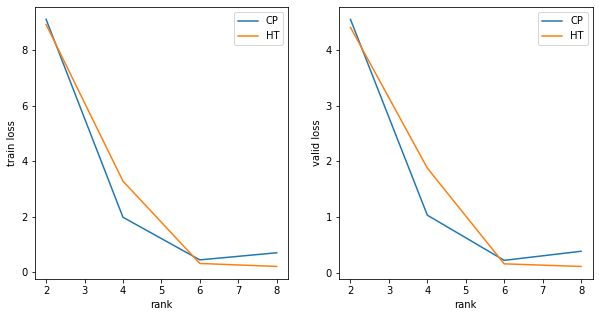

In [30]:
if task == 'classification':
  plt.figure(figsize=(20,5))
  for i in range(1,5):
    plt.subplot(1,4,i)
    plt.plot(rank_list, results_for_different_ranks_means['CP'][:, i-1], label = 'CP' )
    plt.plot(rank_list, results_for_different_ranks_means['HT'][:, i-1], label = 'HT' )
    plt.xlabel('rank')
    plt.legend()

if task == 'regression':
  modes = ['train', 'valid']
  plt.figure(figsize=(10,5))
  for i in range(1,3):
    plt.subplot(1,2,i)
    plt.plot(rank_list, results_for_different_ranks_means['CP'][:, i-1] , label ='CP')
    plt.plot(rank_list, results_for_different_ranks_means['HT'][:, i-1] , label ='HT')
    plt.ylabel(f'{modes[i-1]} loss')
    plt.xlabel('rank')
    plt.legend()



#Check Convergence! Whay test loss increases with rank?!!

In [ ]:
type(dict_all_results['model_CP_rank_2_run_0'])

dict

In [ ]:
dict_all_results['model_CP_rank_2_run_0'].keys()

dict_keys(['losses', 'accuracies'])

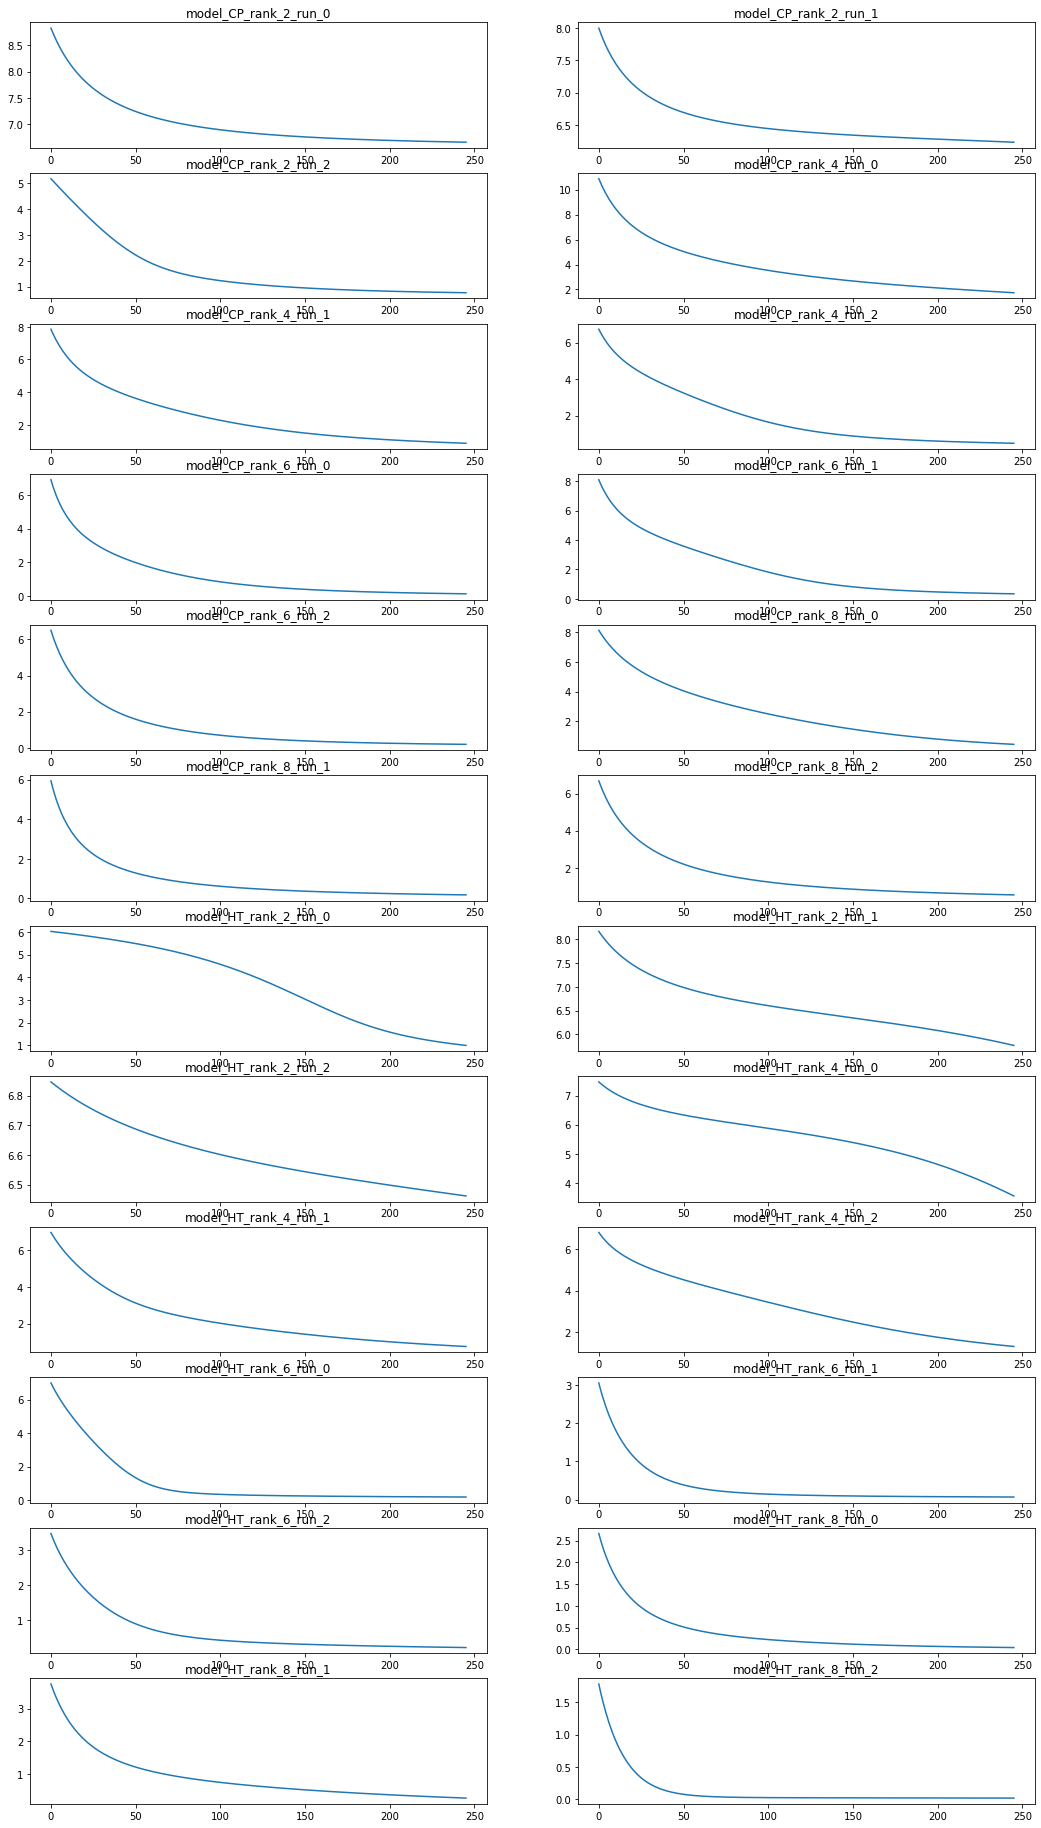

In [31]:
plt.figure(figsize = (18,66))

for i, key in enumerate(dict_all_results.keys()):
  plt.subplot(len(dict_all_results.keys()),2,i+1)
  plt.plot(dict_all_results[key]['losses']['valid'][20:])
  plt.title(key)

In [ ]:
dict_all_results[key]['losses']['valid']

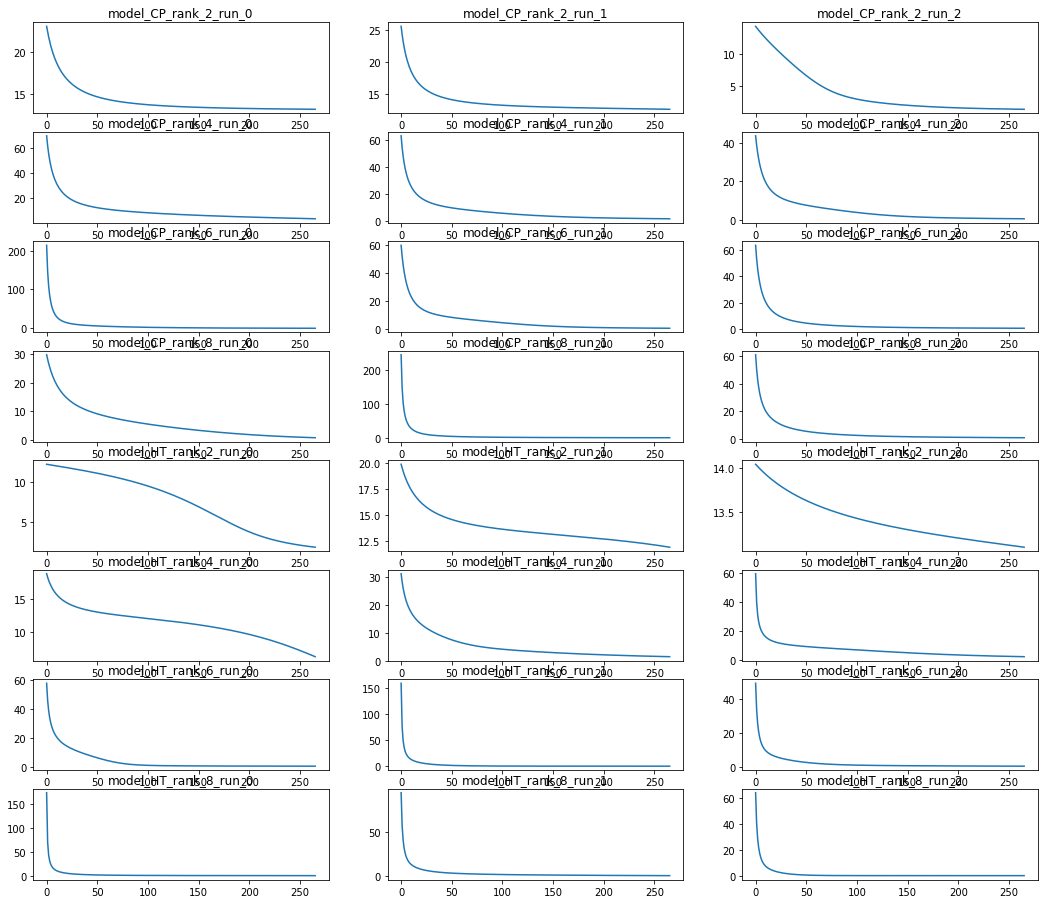

In [32]:
plt.figure(figsize = (18,48))

for i, key in enumerate(dict_all_results.keys()):
  plt.subplot(len(dict_all_results.keys()),3,i+1)
  plt.plot(dict_all_results[key]['losses']['train'])
  plt.title(key)

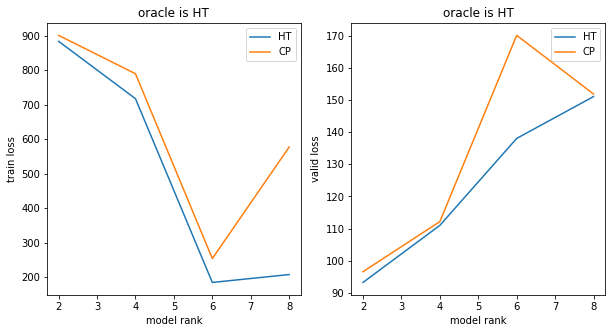

In [ ]:
#list of final epoch's loss for model HT
modes = ['train', 'valid']
loss_list_rank = {'CP': {'train' : None , 'valid': None}  , 'HT': {'train' :None  , 'valid':None } }
for model in model_name_list:
  for mode in modes:
    loss_list_rank[model][mode] =  [ dict_res[model][model_rank]['losses'][mode][-1].cpu().detach().numpy() for model_rank in rank_list]

plt.figure(figsize=(10,5))
for i in range(1,3):
  plt.subplot(1,2,i)
  plt.plot(rank_list, loss_list_rank['HT'][modes[i-1]], label = 'HT')
  plt.plot(rank_list, loss_list_rank['CP'][modes[i-1]], label = 'CP')
  plt.legend()
  plt.xlabel('model rank')
  plt.ylabel(f'{modes[i-1]} loss')
  plt.title(f'oracle is {oracle}')
